출처 : https://tykimos.github.io/2017/04/09/RNN_Layer_Talk/

In [9]:
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense, LSTM

from keras.utils import np_utils
import keras

In [24]:
# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [1]:
code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

In [4]:
# dataset 자르기 위한 함수

def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

In [5]:
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)

(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]


In [19]:
# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

In [20]:
y_train

array([ 8,  1,  7,  8,  9, 10, 11, 11,  4, 11,  9,  9,  9, 10,  8,  1,  7,
        9, 11, 11,  9,  9,  2,  8,  8,  8,  8,  8,  9,  3,  9,  9,  9,  9,
        9, 10,  4, 11,  9,  2, 10,  8,  1,  7,  9, 11, 11,  9,  9,  2])

In [21]:
y_train.shape

(50,)

In [22]:
max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1] #(50,)

print("one hot encoding vector size is ", one_hot_vec_size)

one hot encoding vector size is  12


<br>

### 한 스텝 예측
- 실제 음표 4개를 입력하여 다음 음표 1개를 예측하는 것을 반복
- 모델에 t0, t1, t2, t3를 입력하면 y0 출력

### 곡 전체 예측
- 입력된 초가 4개 음표만을 입력으로 곡 전체를 예측하는 것

<br>

### 다층 퍼셉트론 모델
- 입력 속성이 4개, 출력이 12개(one_hot_vec_size = 12)

In [23]:
model = Sequential()
model.add(Dense(128, input_dim=4, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(one_hot_vec_size, activation='softmax'))

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory() # 손실 이력 객체 생성
history.init()

# 5. 모델 학습시키기
model.fit(x_train, y_train, epochs=2000, batch_size=10, verbose=2, callbacks=[history])

Instructions for updating:
Use tf.cast instead.
Epoch 1/2000
 - 0s - loss: 2.5082 - accuracy: 0.0400
Epoch 2/2000
 - 0s - loss: 2.4220 - accuracy: 0.2800
Epoch 3/2000
 - 0s - loss: 2.3433 - accuracy: 0.3400
Epoch 4/2000
 - 0s - loss: 2.2703 - accuracy: 0.3400
Epoch 5/2000
 - 0s - loss: 2.1922 - accuracy: 0.3400
Epoch 6/2000
 - 0s - loss: 2.1028 - accuracy: 0.3400
Epoch 7/2000
 - 0s - loss: 2.0369 - accuracy: 0.3400
Epoch 8/2000
 - 0s - loss: 1.9673 - accuracy: 0.3400
Epoch 9/2000
 - 0s - loss: 1.9313 - accuracy: 0.3400
Epoch 10/2000
 - 0s - loss: 1.8964 - accuracy: 0.3400
Epoch 11/2000
 - 0s - loss: 1.8738 - accuracy: 0.3400
Epoch 12/2000
 - 0s - loss: 1.8600 - accuracy: 0.3400
Epoch 13/2000
 - 0s - loss: 1.8406 - accuracy: 0.3400
Epoch 14/2000
 - 0s - loss: 1.8245 - accuracy: 0.3400
Epoch 15/2000
 - 0s - loss: 1.8093 - accuracy: 0.3400
Epoch 16/2000
 - 0s - loss: 1.7967 - accuracy: 0.3400
Epoch 17/2000
 - 0s - loss: 1.7804 - accuracy: 0.3400
Epoch 18/2000
 - 0s - loss: 1.7672 - accura

Epoch 148/2000
 - 0s - loss: 1.2096 - accuracy: 0.5600
Epoch 149/2000
 - 0s - loss: 1.2049 - accuracy: 0.5800
Epoch 150/2000
 - 0s - loss: 1.2038 - accuracy: 0.5600
Epoch 151/2000
 - 0s - loss: 1.1951 - accuracy: 0.5600
Epoch 152/2000
 - 0s - loss: 1.1919 - accuracy: 0.5600
Epoch 153/2000
 - 0s - loss: 1.1917 - accuracy: 0.5800
Epoch 154/2000
 - 0s - loss: 1.1905 - accuracy: 0.6000
Epoch 155/2000
 - 0s - loss: 1.1907 - accuracy: 0.6000
Epoch 156/2000
 - 0s - loss: 1.1913 - accuracy: 0.6000
Epoch 157/2000
 - 0s - loss: 1.1824 - accuracy: 0.5800
Epoch 158/2000
 - 0s - loss: 1.1862 - accuracy: 0.5400
Epoch 159/2000
 - 0s - loss: 1.1772 - accuracy: 0.5800
Epoch 160/2000
 - 0s - loss: 1.1759 - accuracy: 0.5800
Epoch 161/2000
 - 0s - loss: 1.1722 - accuracy: 0.6000
Epoch 162/2000
 - 0s - loss: 1.1781 - accuracy: 0.6000
Epoch 163/2000
 - 0s - loss: 1.1736 - accuracy: 0.6000
Epoch 164/2000
 - 0s - loss: 1.1793 - accuracy: 0.5800
Epoch 165/2000
 - 0s - loss: 1.1651 - accuracy: 0.5800
Epoch 166/

Epoch 297/2000
 - 0s - loss: 0.9105 - accuracy: 0.6000
Epoch 298/2000
 - 0s - loss: 0.9112 - accuracy: 0.6200
Epoch 299/2000
 - 0s - loss: 0.9114 - accuracy: 0.6600
Epoch 300/2000
 - 0s - loss: 0.9049 - accuracy: 0.6000
Epoch 301/2000
 - 0s - loss: 0.9010 - accuracy: 0.6400
Epoch 302/2000
 - 0s - loss: 0.9125 - accuracy: 0.6000
Epoch 303/2000
 - 0s - loss: 0.9083 - accuracy: 0.6200
Epoch 304/2000
 - 0s - loss: 0.9029 - accuracy: 0.6200
Epoch 305/2000
 - 0s - loss: 0.9021 - accuracy: 0.6400
Epoch 306/2000
 - 0s - loss: 0.8966 - accuracy: 0.6400
Epoch 307/2000
 - 0s - loss: 0.8939 - accuracy: 0.6400
Epoch 308/2000
 - 0s - loss: 0.8964 - accuracy: 0.6200
Epoch 309/2000
 - 0s - loss: 0.8936 - accuracy: 0.6200
Epoch 310/2000
 - 0s - loss: 0.8926 - accuracy: 0.6600
Epoch 311/2000
 - 0s - loss: 0.8889 - accuracy: 0.6400
Epoch 312/2000
 - 0s - loss: 0.8859 - accuracy: 0.6200
Epoch 313/2000
 - 0s - loss: 0.8866 - accuracy: 0.6600
Epoch 314/2000
 - 0s - loss: 0.8848 - accuracy: 0.6400
Epoch 315/

Epoch 446/2000
 - 0s - loss: 0.7009 - accuracy: 0.7200
Epoch 447/2000
 - 0s - loss: 0.7136 - accuracy: 0.7200
Epoch 448/2000
 - 0s - loss: 0.7022 - accuracy: 0.7600
Epoch 449/2000
 - 0s - loss: 0.6983 - accuracy: 0.7600
Epoch 450/2000
 - 0s - loss: 0.7062 - accuracy: 0.7400
Epoch 451/2000
 - 0s - loss: 0.7061 - accuracy: 0.7400
Epoch 452/2000
 - 0s - loss: 0.6979 - accuracy: 0.7400
Epoch 453/2000
 - 0s - loss: 0.6921 - accuracy: 0.7400
Epoch 454/2000
 - 0s - loss: 0.6942 - accuracy: 0.7400
Epoch 455/2000
 - 0s - loss: 0.6900 - accuracy: 0.7400
Epoch 456/2000
 - 0s - loss: 0.6964 - accuracy: 0.7400
Epoch 457/2000
 - 0s - loss: 0.6886 - accuracy: 0.7400
Epoch 458/2000
 - 0s - loss: 0.6907 - accuracy: 0.7400
Epoch 459/2000
 - 0s - loss: 0.6915 - accuracy: 0.7400
Epoch 460/2000
 - 0s - loss: 0.6847 - accuracy: 0.7400
Epoch 461/2000
 - 0s - loss: 0.6845 - accuracy: 0.7400
Epoch 462/2000
 - 0s - loss: 0.6782 - accuracy: 0.7400
Epoch 463/2000
 - 0s - loss: 0.6875 - accuracy: 0.7400
Epoch 464/

Epoch 595/2000
 - 0s - loss: 0.5515 - accuracy: 0.7600
Epoch 596/2000
 - 0s - loss: 0.5500 - accuracy: 0.7800
Epoch 597/2000
 - 0s - loss: 0.5490 - accuracy: 0.8000
Epoch 598/2000
 - 0s - loss: 0.5493 - accuracy: 0.7800
Epoch 599/2000
 - 0s - loss: 0.5519 - accuracy: 0.7600
Epoch 600/2000
 - 0s - loss: 0.5467 - accuracy: 0.7800
Epoch 601/2000
 - 0s - loss: 0.5435 - accuracy: 0.7800
Epoch 602/2000
 - 0s - loss: 0.5479 - accuracy: 0.7800
Epoch 603/2000
 - 0s - loss: 0.5494 - accuracy: 0.7800
Epoch 604/2000
 - 0s - loss: 0.5462 - accuracy: 0.8000
Epoch 605/2000
 - 0s - loss: 0.5535 - accuracy: 0.8000
Epoch 606/2000
 - 0s - loss: 0.5417 - accuracy: 0.7800
Epoch 607/2000
 - 0s - loss: 0.5466 - accuracy: 0.8200
Epoch 608/2000
 - 0s - loss: 0.5476 - accuracy: 0.8200
Epoch 609/2000
 - 0s - loss: 0.5692 - accuracy: 0.7800
Epoch 610/2000
 - 0s - loss: 0.5415 - accuracy: 0.7600
Epoch 611/2000
 - 0s - loss: 0.5533 - accuracy: 0.7600
Epoch 612/2000
 - 0s - loss: 0.5372 - accuracy: 0.8000
Epoch 613/

Epoch 744/2000
 - 0s - loss: 0.4570 - accuracy: 0.8400
Epoch 745/2000
 - 0s - loss: 0.4688 - accuracy: 0.8400
Epoch 746/2000
 - 0s - loss: 0.4532 - accuracy: 0.8400
Epoch 747/2000
 - 0s - loss: 0.4468 - accuracy: 0.8400
Epoch 748/2000
 - 0s - loss: 0.4502 - accuracy: 0.8000
Epoch 749/2000
 - 0s - loss: 0.4566 - accuracy: 0.8200
Epoch 750/2000
 - 0s - loss: 0.4463 - accuracy: 0.8400
Epoch 751/2000
 - 0s - loss: 0.4502 - accuracy: 0.8200
Epoch 752/2000
 - 0s - loss: 0.4629 - accuracy: 0.8400
Epoch 753/2000
 - 0s - loss: 0.4612 - accuracy: 0.8000
Epoch 754/2000
 - 0s - loss: 0.4457 - accuracy: 0.8200
Epoch 755/2000
 - 0s - loss: 0.4471 - accuracy: 0.8600
Epoch 756/2000
 - 0s - loss: 0.4446 - accuracy: 0.8600
Epoch 757/2000
 - 0s - loss: 0.4467 - accuracy: 0.8400
Epoch 758/2000
 - 0s - loss: 0.4385 - accuracy: 0.8200
Epoch 759/2000
 - 0s - loss: 0.4438 - accuracy: 0.8200
Epoch 760/2000
 - 0s - loss: 0.4421 - accuracy: 0.8600
Epoch 761/2000
 - 0s - loss: 0.4413 - accuracy: 0.8000
Epoch 762/

Epoch 893/2000
 - 0s - loss: 0.3771 - accuracy: 0.8400
Epoch 894/2000
 - 0s - loss: 0.3862 - accuracy: 0.8400
Epoch 895/2000
 - 0s - loss: 0.3731 - accuracy: 0.8400
Epoch 896/2000
 - 0s - loss: 0.3863 - accuracy: 0.8400
Epoch 897/2000
 - 0s - loss: 0.3762 - accuracy: 0.8200
Epoch 898/2000
 - 0s - loss: 0.3716 - accuracy: 0.8400
Epoch 899/2000
 - 0s - loss: 0.3794 - accuracy: 0.8400
Epoch 900/2000
 - 0s - loss: 0.3727 - accuracy: 0.8600
Epoch 901/2000
 - 0s - loss: 0.3800 - accuracy: 0.8400
Epoch 902/2000
 - 0s - loss: 0.3761 - accuracy: 0.8400
Epoch 903/2000
 - 0s - loss: 0.3774 - accuracy: 0.8600
Epoch 904/2000
 - 0s - loss: 0.3782 - accuracy: 0.8800
Epoch 905/2000
 - 0s - loss: 0.3733 - accuracy: 0.8800
Epoch 906/2000
 - 0s - loss: 0.3713 - accuracy: 0.8400
Epoch 907/2000
 - 0s - loss: 0.3717 - accuracy: 0.8600
Epoch 908/2000
 - 0s - loss: 0.3624 - accuracy: 0.8400
Epoch 909/2000
 - 0s - loss: 0.3721 - accuracy: 0.8600
Epoch 910/2000
 - 0s - loss: 0.3751 - accuracy: 0.8200
Epoch 911/

Epoch 1042/2000
 - 0s - loss: 0.3284 - accuracy: 0.9000
Epoch 1043/2000
 - 0s - loss: 0.3193 - accuracy: 0.8800
Epoch 1044/2000
 - 0s - loss: 0.3176 - accuracy: 0.8800
Epoch 1045/2000
 - 0s - loss: 0.3363 - accuracy: 0.8800
Epoch 1046/2000
 - 0s - loss: 0.3204 - accuracy: 0.8800
Epoch 1047/2000
 - 0s - loss: 0.3308 - accuracy: 0.8800
Epoch 1048/2000
 - 0s - loss: 0.3450 - accuracy: 0.8000
Epoch 1049/2000
 - 0s - loss: 0.3223 - accuracy: 0.9000
Epoch 1050/2000
 - 0s - loss: 0.3358 - accuracy: 0.8600
Epoch 1051/2000
 - 0s - loss: 0.3271 - accuracy: 0.8800
Epoch 1052/2000
 - 0s - loss: 0.3155 - accuracy: 0.8600
Epoch 1053/2000
 - 0s - loss: 0.3233 - accuracy: 0.8800
Epoch 1054/2000
 - 0s - loss: 0.3094 - accuracy: 0.9000
Epoch 1055/2000
 - 0s - loss: 0.3206 - accuracy: 0.9200
Epoch 1056/2000
 - 0s - loss: 0.3237 - accuracy: 0.9000
Epoch 1057/2000
 - 0s - loss: 0.3193 - accuracy: 0.8600
Epoch 1058/2000
 - 0s - loss: 0.3111 - accuracy: 0.9200
Epoch 1059/2000
 - 0s - loss: 0.3177 - accuracy:

Epoch 1189/2000
 - 0s - loss: 0.2791 - accuracy: 0.8800
Epoch 1190/2000
 - 0s - loss: 0.2801 - accuracy: 0.9200
Epoch 1191/2000
 - 0s - loss: 0.2774 - accuracy: 0.9000
Epoch 1192/2000
 - 0s - loss: 0.2825 - accuracy: 0.8800
Epoch 1193/2000
 - 0s - loss: 0.2789 - accuracy: 0.9200
Epoch 1194/2000
 - 0s - loss: 0.2970 - accuracy: 0.8800
Epoch 1195/2000
 - 0s - loss: 0.2967 - accuracy: 0.9000
Epoch 1196/2000
 - 0s - loss: 0.2750 - accuracy: 0.9200
Epoch 1197/2000
 - 0s - loss: 0.2725 - accuracy: 0.9200
Epoch 1198/2000
 - 0s - loss: 0.2817 - accuracy: 0.8800
Epoch 1199/2000
 - 0s - loss: 0.2739 - accuracy: 0.9000
Epoch 1200/2000
 - 0s - loss: 0.2710 - accuracy: 0.9200
Epoch 1201/2000
 - 0s - loss: 0.2795 - accuracy: 0.8800
Epoch 1202/2000
 - 0s - loss: 0.2688 - accuracy: 0.9200
Epoch 1203/2000
 - 0s - loss: 0.2756 - accuracy: 0.9200
Epoch 1204/2000
 - 0s - loss: 0.2776 - accuracy: 0.9200
Epoch 1205/2000
 - 0s - loss: 0.2779 - accuracy: 0.8400
Epoch 1206/2000
 - 0s - loss: 0.2729 - accuracy:

Epoch 1336/2000
 - 0s - loss: 0.2477 - accuracy: 0.9000
Epoch 1337/2000
 - 0s - loss: 0.2414 - accuracy: 0.9200
Epoch 1338/2000
 - 0s - loss: 0.2388 - accuracy: 0.9200
Epoch 1339/2000
 - 0s - loss: 0.2470 - accuracy: 0.9000
Epoch 1340/2000
 - 0s - loss: 0.2471 - accuracy: 0.9200
Epoch 1341/2000
 - 0s - loss: 0.2402 - accuracy: 0.9000
Epoch 1342/2000
 - 0s - loss: 0.2442 - accuracy: 0.9000
Epoch 1343/2000
 - 0s - loss: 0.2389 - accuracy: 0.9200
Epoch 1344/2000
 - 0s - loss: 0.2432 - accuracy: 0.9200
Epoch 1345/2000
 - 0s - loss: 0.2584 - accuracy: 0.8800
Epoch 1346/2000
 - 0s - loss: 0.2423 - accuracy: 0.9200
Epoch 1347/2000
 - 0s - loss: 0.2724 - accuracy: 0.8800
Epoch 1348/2000
 - 0s - loss: 0.2555 - accuracy: 0.9000
Epoch 1349/2000
 - 0s - loss: 0.2523 - accuracy: 0.9200
Epoch 1350/2000
 - 0s - loss: 0.2443 - accuracy: 0.9200
Epoch 1351/2000
 - 0s - loss: 0.2375 - accuracy: 0.9200
Epoch 1352/2000
 - 0s - loss: 0.2425 - accuracy: 0.9000
Epoch 1353/2000
 - 0s - loss: 0.2428 - accuracy:

Epoch 1483/2000
 - 0s - loss: 0.2482 - accuracy: 0.8400
Epoch 1484/2000
 - 0s - loss: 0.2179 - accuracy: 0.9200
Epoch 1485/2000
 - 0s - loss: 0.2096 - accuracy: 0.9200
Epoch 1486/2000
 - 0s - loss: 0.2159 - accuracy: 0.9200
Epoch 1487/2000
 - 0s - loss: 0.2153 - accuracy: 0.8800
Epoch 1488/2000
 - 0s - loss: 0.2135 - accuracy: 0.9000
Epoch 1489/2000
 - 0s - loss: 0.2092 - accuracy: 0.9200
Epoch 1490/2000
 - 0s - loss: 0.2165 - accuracy: 0.9200
Epoch 1491/2000
 - 0s - loss: 0.2239 - accuracy: 0.9000
Epoch 1492/2000
 - 0s - loss: 0.2245 - accuracy: 0.8800
Epoch 1493/2000
 - 0s - loss: 0.2288 - accuracy: 0.9000
Epoch 1494/2000
 - 0s - loss: 0.2115 - accuracy: 0.9200
Epoch 1495/2000
 - 0s - loss: 0.2348 - accuracy: 0.9200
Epoch 1496/2000
 - 0s - loss: 0.2170 - accuracy: 0.9000
Epoch 1497/2000
 - 0s - loss: 0.2152 - accuracy: 0.9200
Epoch 1498/2000
 - 0s - loss: 0.2092 - accuracy: 0.9200
Epoch 1499/2000
 - 0s - loss: 0.2095 - accuracy: 0.9200
Epoch 1500/2000
 - 0s - loss: 0.2181 - accuracy:

Epoch 1630/2000
 - 0s - loss: 0.1994 - accuracy: 0.9000
Epoch 1631/2000
 - 0s - loss: 0.1990 - accuracy: 0.9200
Epoch 1632/2000
 - 0s - loss: 0.1985 - accuracy: 0.9000
Epoch 1633/2000
 - 0s - loss: 0.1961 - accuracy: 0.9200
Epoch 1634/2000
 - 0s - loss: 0.2004 - accuracy: 0.9200
Epoch 1635/2000
 - 0s - loss: 0.2132 - accuracy: 0.8800
Epoch 1636/2000
 - 0s - loss: 0.1919 - accuracy: 0.9200
Epoch 1637/2000
 - 0s - loss: 0.1922 - accuracy: 0.9200
Epoch 1638/2000
 - 0s - loss: 0.2159 - accuracy: 0.9000
Epoch 1639/2000
 - 0s - loss: 0.1949 - accuracy: 0.9200
Epoch 1640/2000
 - 0s - loss: 0.1894 - accuracy: 0.9200
Epoch 1641/2000
 - 0s - loss: 0.1973 - accuracy: 0.9200
Epoch 1642/2000
 - 0s - loss: 0.1940 - accuracy: 0.9200
Epoch 1643/2000
 - 0s - loss: 0.2042 - accuracy: 0.9000
Epoch 1644/2000
 - 0s - loss: 0.2170 - accuracy: 0.9000
Epoch 1645/2000
 - 0s - loss: 0.1968 - accuracy: 0.9200
Epoch 1646/2000
 - 0s - loss: 0.1938 - accuracy: 0.9200
Epoch 1647/2000
 - 0s - loss: 0.2009 - accuracy:

Epoch 1777/2000
 - 0s - loss: 0.1910 - accuracy: 0.9000
Epoch 1778/2000
 - 0s - loss: 0.1830 - accuracy: 0.9200
Epoch 1779/2000
 - 0s - loss: 0.1940 - accuracy: 0.8800
Epoch 1780/2000
 - 0s - loss: 0.1811 - accuracy: 0.9200
Epoch 1781/2000
 - 0s - loss: 0.1917 - accuracy: 0.9000
Epoch 1782/2000
 - 0s - loss: 0.1951 - accuracy: 0.9000
Epoch 1783/2000
 - 0s - loss: 0.1809 - accuracy: 0.9200
Epoch 1784/2000
 - 0s - loss: 0.1784 - accuracy: 0.9000
Epoch 1785/2000
 - 0s - loss: 0.1867 - accuracy: 0.9200
Epoch 1786/2000
 - 0s - loss: 0.1943 - accuracy: 0.9000
Epoch 1787/2000
 - 0s - loss: 0.1828 - accuracy: 0.9200
Epoch 1788/2000
 - 0s - loss: 0.1969 - accuracy: 0.8800
Epoch 1789/2000
 - 0s - loss: 0.1881 - accuracy: 0.9000
Epoch 1790/2000
 - 0s - loss: 0.1848 - accuracy: 0.9200
Epoch 1791/2000
 - 0s - loss: 0.2069 - accuracy: 0.8600
Epoch 1792/2000
 - 0s - loss: 0.2013 - accuracy: 0.9200
Epoch 1793/2000
 - 0s - loss: 0.1804 - accuracy: 0.9200
Epoch 1794/2000
 - 0s - loss: 0.1850 - accuracy:

Epoch 1924/2000
 - 0s - loss: 0.1800 - accuracy: 0.8600
Epoch 1925/2000
 - 0s - loss: 0.1846 - accuracy: 0.8800
Epoch 1926/2000
 - 0s - loss: 0.1758 - accuracy: 0.9200
Epoch 1927/2000
 - 0s - loss: 0.1734 - accuracy: 0.9200
Epoch 1928/2000
 - 0s - loss: 0.1785 - accuracy: 0.9000
Epoch 1929/2000
 - 0s - loss: 0.2049 - accuracy: 0.9000
Epoch 1930/2000
 - 0s - loss: 0.1771 - accuracy: 0.9200
Epoch 1931/2000
 - 0s - loss: 0.1767 - accuracy: 0.9000
Epoch 1932/2000
 - 0s - loss: 0.1849 - accuracy: 0.9200
Epoch 1933/2000
 - 0s - loss: 0.1702 - accuracy: 0.9200
Epoch 1934/2000
 - 0s - loss: 0.1744 - accuracy: 0.9000
Epoch 1935/2000
 - 0s - loss: 0.1669 - accuracy: 0.9200
Epoch 1936/2000
 - 0s - loss: 0.1821 - accuracy: 0.8800
Epoch 1937/2000
 - 0s - loss: 0.1832 - accuracy: 0.9200
Epoch 1938/2000
 - 0s - loss: 0.1772 - accuracy: 0.9200
Epoch 1939/2000
 - 0s - loss: 0.1671 - accuracy: 0.9200
Epoch 1940/2000
 - 0s - loss: 0.2052 - accuracy: 0.8800
Epoch 1941/2000
 - 0s - loss: 0.1824 - accuracy:

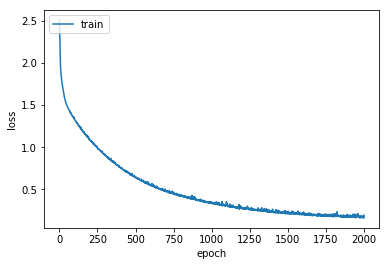

In [26]:
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [28]:
# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의


50/50 [==============================] - 0s 1ms/step
accuracy: 92.00%


In [29]:
# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

one step prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'g4', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'e8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']


In [30]:
# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4)) # batch_size, feature
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)

full song prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8']


<br>

### LSTM

In [31]:
model = Sequential()
model.add(LSTM(128, input_shape = (4, 1)))
model.add(Dense(one_hot_vec_size, activation='softmax'))

- 타임스텝 : 하나의 샘플에 포함된 시퀀스 개수
- input_shape = (4,1) == input_dim = 1, input_length =4
- 상태유지 : 현재 학습된 상태가 다음 학습시 초기 상태로 전달된다는 것
    - 내부적으로 기억할 것은 기억하고 버릴 것은 버려서 기억해야 할 중요한 정보만 가지고 감
    - `stateful = True`
    

In [33]:
x_train = np.reshape(x_train, (50, 4, 1)) # 샘플 수, 타임스텝 수, 속성 수

Epoch 1/2000
 - 1s - loss: 2.4907 - accuracy: 0.0800
Epoch 2/2000
 - 0s - loss: 2.4447 - accuracy: 0.3200
Epoch 3/2000
 - 0s - loss: 2.4050 - accuracy: 0.3400
Epoch 4/2000
 - 0s - loss: 2.3617 - accuracy: 0.3400
Epoch 5/2000
 - 0s - loss: 2.3129 - accuracy: 0.3400
Epoch 6/2000
 - 0s - loss: 2.2519 - accuracy: 0.3400
Epoch 7/2000
 - 0s - loss: 2.1872 - accuracy: 0.3400
Epoch 8/2000
 - 0s - loss: 2.1032 - accuracy: 0.3400
Epoch 9/2000
 - 0s - loss: 2.0387 - accuracy: 0.3400
Epoch 10/2000
 - 0s - loss: 1.9897 - accuracy: 0.3400
Epoch 11/2000
 - 0s - loss: 1.9799 - accuracy: 0.3400
Epoch 12/2000
 - 0s - loss: 1.9634 - accuracy: 0.3400
Epoch 13/2000
 - 0s - loss: 1.9465 - accuracy: 0.3400
Epoch 14/2000
 - 0s - loss: 1.9286 - accuracy: 0.3400
Epoch 15/2000
 - 0s - loss: 1.9312 - accuracy: 0.3400
Epoch 16/2000
 - 0s - loss: 1.9216 - accuracy: 0.3400
Epoch 17/2000
 - 0s - loss: 1.9185 - accuracy: 0.3400
Epoch 18/2000
 - 0s - loss: 1.9097 - accuracy: 0.3400
Epoch 19/2000
 - 0s - loss: 1.9078 - 

Epoch 152/2000
 - 0s - loss: 1.6048 - accuracy: 0.4200
Epoch 153/2000
 - 0s - loss: 1.5691 - accuracy: 0.4200
Epoch 154/2000
 - 0s - loss: 1.5633 - accuracy: 0.4600
Epoch 155/2000
 - 0s - loss: 1.5801 - accuracy: 0.4600
Epoch 156/2000
 - 0s - loss: 1.5805 - accuracy: 0.4400
Epoch 157/2000
 - 0s - loss: 1.5690 - accuracy: 0.4600
Epoch 158/2000
 - 0s - loss: 1.5628 - accuracy: 0.4400
Epoch 159/2000
 - 0s - loss: 1.5592 - accuracy: 0.4200
Epoch 160/2000
 - 0s - loss: 1.5618 - accuracy: 0.4400
Epoch 161/2000
 - 0s - loss: 1.5519 - accuracy: 0.4400
Epoch 162/2000
 - 0s - loss: 1.5488 - accuracy: 0.4800
Epoch 163/2000
 - 0s - loss: 1.5440 - accuracy: 0.4400
Epoch 164/2000
 - 0s - loss: 1.5400 - accuracy: 0.4400
Epoch 165/2000
 - 0s - loss: 1.5462 - accuracy: 0.4600
Epoch 166/2000
 - 0s - loss: 1.5347 - accuracy: 0.4600
Epoch 167/2000
 - 0s - loss: 1.5486 - accuracy: 0.4400
Epoch 168/2000
 - 0s - loss: 1.5573 - accuracy: 0.4600
Epoch 169/2000
 - 0s - loss: 1.5353 - accuracy: 0.4400
Epoch 170/

Epoch 301/2000
 - 0s - loss: 1.2293 - accuracy: 0.5200
Epoch 302/2000
 - 0s - loss: 1.2453 - accuracy: 0.5200
Epoch 303/2000
 - 0s - loss: 1.2552 - accuracy: 0.5600
Epoch 304/2000
 - 0s - loss: 1.2200 - accuracy: 0.5800
Epoch 305/2000
 - 0s - loss: 1.2619 - accuracy: 0.5200
Epoch 306/2000
 - 0s - loss: 1.2194 - accuracy: 0.5000
Epoch 307/2000
 - 0s - loss: 1.2333 - accuracy: 0.5600
Epoch 308/2000
 - 0s - loss: 1.2402 - accuracy: 0.5200
Epoch 309/2000
 - 0s - loss: 1.2320 - accuracy: 0.5000
Epoch 310/2000
 - 0s - loss: 1.2108 - accuracy: 0.5800
Epoch 311/2000
 - 0s - loss: 1.2198 - accuracy: 0.5800
Epoch 312/2000
 - 0s - loss: 1.2044 - accuracy: 0.5000
Epoch 313/2000
 - 0s - loss: 1.2020 - accuracy: 0.5000
Epoch 314/2000
 - 0s - loss: 1.2202 - accuracy: 0.5800
Epoch 315/2000
 - 0s - loss: 1.2115 - accuracy: 0.5800
Epoch 316/2000
 - 0s - loss: 1.2144 - accuracy: 0.5200
Epoch 317/2000
 - 0s - loss: 1.2213 - accuracy: 0.5000
Epoch 318/2000
 - 0s - loss: 1.1926 - accuracy: 0.5200
Epoch 319/

Epoch 450/2000
 - 0s - loss: 0.8986 - accuracy: 0.6400
Epoch 451/2000
 - 0s - loss: 0.9030 - accuracy: 0.6800
Epoch 452/2000
 - 0s - loss: 0.8967 - accuracy: 0.6400
Epoch 453/2000
 - 0s - loss: 0.8895 - accuracy: 0.6400
Epoch 454/2000
 - 0s - loss: 0.8782 - accuracy: 0.6400
Epoch 455/2000
 - 0s - loss: 0.8773 - accuracy: 0.6600
Epoch 456/2000
 - 0s - loss: 0.8734 - accuracy: 0.6400
Epoch 457/2000
 - 0s - loss: 0.8908 - accuracy: 0.6200
Epoch 458/2000
 - 0s - loss: 0.8677 - accuracy: 0.6400
Epoch 459/2000
 - 0s - loss: 0.9127 - accuracy: 0.6200
Epoch 460/2000
 - 0s - loss: 0.8827 - accuracy: 0.6800
Epoch 461/2000
 - 0s - loss: 0.8965 - accuracy: 0.6000
Epoch 462/2000
 - 0s - loss: 0.8747 - accuracy: 0.6200
Epoch 463/2000
 - 0s - loss: 0.8567 - accuracy: 0.6200
Epoch 464/2000
 - 0s - loss: 0.8671 - accuracy: 0.6600
Epoch 465/2000
 - 0s - loss: 0.8779 - accuracy: 0.6200
Epoch 466/2000
 - 0s - loss: 0.8416 - accuracy: 0.6800
Epoch 467/2000
 - 0s - loss: 0.8605 - accuracy: 0.6000
Epoch 468/

Epoch 599/2000
 - 0s - loss: 0.6151 - accuracy: 0.8000
Epoch 600/2000
 - 0s - loss: 0.6327 - accuracy: 0.7600
Epoch 601/2000
 - 0s - loss: 0.6181 - accuracy: 0.7400
Epoch 602/2000
 - 0s - loss: 0.6557 - accuracy: 0.7600
Epoch 603/2000
 - 0s - loss: 0.6445 - accuracy: 0.7800
Epoch 604/2000
 - 0s - loss: 0.6017 - accuracy: 0.8200
Epoch 605/2000
 - 0s - loss: 0.6246 - accuracy: 0.8400
Epoch 606/2000
 - 0s - loss: 0.6252 - accuracy: 0.8200
Epoch 607/2000
 - 0s - loss: 0.6061 - accuracy: 0.8000
Epoch 608/2000
 - 0s - loss: 0.6130 - accuracy: 0.7800
Epoch 609/2000
 - 0s - loss: 0.6682 - accuracy: 0.7400
Epoch 610/2000
 - 0s - loss: 0.6077 - accuracy: 0.7800
Epoch 611/2000
 - 0s - loss: 0.6469 - accuracy: 0.7600
Epoch 612/2000
 - 0s - loss: 0.6119 - accuracy: 0.8000
Epoch 613/2000
 - 0s - loss: 0.6446 - accuracy: 0.7600
Epoch 614/2000
 - 0s - loss: 0.5943 - accuracy: 0.8000
Epoch 615/2000
 - 0s - loss: 0.6208 - accuracy: 0.8000
Epoch 616/2000
 - 0s - loss: 0.6046 - accuracy: 0.7800
Epoch 617/

Epoch 748/2000
 - 0s - loss: 0.4835 - accuracy: 0.8400
Epoch 749/2000
 - 0s - loss: 0.5034 - accuracy: 0.8400
Epoch 750/2000
 - 0s - loss: 0.4951 - accuracy: 0.8600
Epoch 751/2000
 - 0s - loss: 0.5000 - accuracy: 0.8200
Epoch 752/2000
 - 0s - loss: 0.5113 - accuracy: 0.8400
Epoch 753/2000
 - 0s - loss: 0.5110 - accuracy: 0.8200
Epoch 754/2000
 - 0s - loss: 0.5401 - accuracy: 0.8200
Epoch 755/2000
 - 0s - loss: 0.4980 - accuracy: 0.8400
Epoch 756/2000
 - 0s - loss: 0.5021 - accuracy: 0.8000
Epoch 757/2000
 - 0s - loss: 0.5336 - accuracy: 0.8000
Epoch 758/2000
 - 0s - loss: 0.4766 - accuracy: 0.8400
Epoch 759/2000
 - 0s - loss: 0.5777 - accuracy: 0.7600
Epoch 760/2000
 - 0s - loss: 0.4905 - accuracy: 0.8400
Epoch 761/2000
 - 0s - loss: 0.4976 - accuracy: 0.8600
Epoch 762/2000
 - 0s - loss: 0.4898 - accuracy: 0.8400
Epoch 763/2000
 - 0s - loss: 0.4883 - accuracy: 0.8200
Epoch 764/2000
 - 0s - loss: 0.4939 - accuracy: 0.8600
Epoch 765/2000
 - 0s - loss: 0.5002 - accuracy: 0.8600
Epoch 766/

Epoch 897/2000
 - 0s - loss: 0.4381 - accuracy: 0.8600
Epoch 898/2000
 - 0s - loss: 0.4581 - accuracy: 0.8200
Epoch 899/2000
 - 0s - loss: 0.4286 - accuracy: 0.8600
Epoch 900/2000
 - 0s - loss: 0.4403 - accuracy: 0.8600
Epoch 901/2000
 - 0s - loss: 0.4492 - accuracy: 0.8400
Epoch 902/2000
 - 0s - loss: 0.4375 - accuracy: 0.8400
Epoch 903/2000
 - 0s - loss: 0.4321 - accuracy: 0.8600
Epoch 904/2000
 - 0s - loss: 0.4279 - accuracy: 0.8600
Epoch 905/2000
 - 0s - loss: 0.4340 - accuracy: 0.8400
Epoch 906/2000
 - 0s - loss: 0.4329 - accuracy: 0.8400
Epoch 907/2000
 - 0s - loss: 0.4408 - accuracy: 0.8400
Epoch 908/2000
 - 0s - loss: 0.4612 - accuracy: 0.8600
Epoch 909/2000
 - 0s - loss: 0.4595 - accuracy: 0.8200
Epoch 910/2000
 - 0s - loss: 0.4630 - accuracy: 0.8200
Epoch 911/2000
 - 0s - loss: 0.4560 - accuracy: 0.8400
Epoch 912/2000
 - 0s - loss: 0.4359 - accuracy: 0.8800
Epoch 913/2000
 - 0s - loss: 0.4252 - accuracy: 0.8400
Epoch 914/2000
 - 0s - loss: 0.4237 - accuracy: 0.8600
Epoch 915/

Epoch 1046/2000
 - 0s - loss: 0.4111 - accuracy: 0.8600
Epoch 1047/2000
 - 0s - loss: 0.4056 - accuracy: 0.8400
Epoch 1048/2000
 - 0s - loss: 0.4076 - accuracy: 0.8600
Epoch 1049/2000
 - 0s - loss: 0.4123 - accuracy: 0.8200
Epoch 1050/2000
 - 0s - loss: 0.3964 - accuracy: 0.8600
Epoch 1051/2000
 - 0s - loss: 0.4067 - accuracy: 0.8600
Epoch 1052/2000
 - 0s - loss: 0.3955 - accuracy: 0.8600
Epoch 1053/2000
 - 0s - loss: 0.4067 - accuracy: 0.8600
Epoch 1054/2000
 - 0s - loss: 0.3903 - accuracy: 0.8600
Epoch 1055/2000
 - 0s - loss: 0.3906 - accuracy: 0.8600
Epoch 1056/2000
 - 0s - loss: 0.4009 - accuracy: 0.8600
Epoch 1057/2000
 - 0s - loss: 0.3813 - accuracy: 0.8800
Epoch 1058/2000
 - 0s - loss: 0.4069 - accuracy: 0.8600
Epoch 1059/2000
 - 0s - loss: 0.3774 - accuracy: 0.8400
Epoch 1060/2000
 - 0s - loss: 0.3906 - accuracy: 0.8800
Epoch 1061/2000
 - 0s - loss: 0.3903 - accuracy: 0.8600
Epoch 1062/2000
 - 0s - loss: 0.3916 - accuracy: 0.8600
Epoch 1063/2000
 - 0s - loss: 0.3991 - accuracy:

Epoch 1193/2000
 - 0s - loss: 0.3506 - accuracy: 0.8600
Epoch 1194/2000
 - 0s - loss: 0.3550 - accuracy: 0.8600
Epoch 1195/2000
 - 0s - loss: 0.3521 - accuracy: 0.8800
Epoch 1196/2000
 - 0s - loss: 0.3558 - accuracy: 0.8400
Epoch 1197/2000
 - 0s - loss: 0.3556 - accuracy: 0.8800
Epoch 1198/2000
 - 0s - loss: 0.3547 - accuracy: 0.8800
Epoch 1199/2000
 - 0s - loss: 0.3575 - accuracy: 0.8600
Epoch 1200/2000
 - 0s - loss: 0.3554 - accuracy: 0.8800
Epoch 1201/2000
 - 0s - loss: 0.3546 - accuracy: 0.8600
Epoch 1202/2000
 - 0s - loss: 0.3699 - accuracy: 0.8200
Epoch 1203/2000
 - 0s - loss: 0.3760 - accuracy: 0.8400
Epoch 1204/2000
 - 0s - loss: 0.3682 - accuracy: 0.8400
Epoch 1205/2000
 - 0s - loss: 0.3562 - accuracy: 0.8600
Epoch 1206/2000
 - 0s - loss: 0.3639 - accuracy: 0.8800
Epoch 1207/2000
 - 0s - loss: 0.3846 - accuracy: 0.8600
Epoch 1208/2000
 - 0s - loss: 0.4171 - accuracy: 0.8400
Epoch 1209/2000
 - 0s - loss: 0.3439 - accuracy: 0.8800
Epoch 1210/2000
 - 0s - loss: 0.3966 - accuracy:

Epoch 1340/2000
 - 0s - loss: 0.3990 - accuracy: 0.8200
Epoch 1341/2000
 - 0s - loss: 0.3388 - accuracy: 0.8600
Epoch 1342/2000
 - 0s - loss: 0.3665 - accuracy: 0.9000
Epoch 1343/2000
 - 0s - loss: 0.3620 - accuracy: 0.8800
Epoch 1344/2000
 - 0s - loss: 0.3587 - accuracy: 0.8800
Epoch 1345/2000
 - 0s - loss: 0.3537 - accuracy: 0.8800
Epoch 1346/2000
 - 0s - loss: 0.3367 - accuracy: 0.8600
Epoch 1347/2000
 - 0s - loss: 0.3474 - accuracy: 0.8600
Epoch 1348/2000
 - 0s - loss: 0.3282 - accuracy: 0.8800
Epoch 1349/2000
 - 0s - loss: 0.3463 - accuracy: 0.9000
Epoch 1350/2000
 - 0s - loss: 0.3354 - accuracy: 0.8600
Epoch 1351/2000
 - 0s - loss: 0.3421 - accuracy: 0.8600
Epoch 1352/2000
 - 0s - loss: 0.3901 - accuracy: 0.8600
Epoch 1353/2000
 - 0s - loss: 0.3350 - accuracy: 0.8800
Epoch 1354/2000
 - 0s - loss: 0.3402 - accuracy: 0.8600
Epoch 1355/2000
 - 0s - loss: 0.3414 - accuracy: 0.8800
Epoch 1356/2000
 - 0s - loss: 0.3313 - accuracy: 0.8600
Epoch 1357/2000
 - 0s - loss: 0.3357 - accuracy:

Epoch 1487/2000
 - 0s - loss: 0.3222 - accuracy: 0.9000
Epoch 1488/2000
 - 0s - loss: 0.3183 - accuracy: 0.8800
Epoch 1489/2000
 - 0s - loss: 0.3327 - accuracy: 0.8800
Epoch 1490/2000
 - 0s - loss: 0.3173 - accuracy: 0.8800
Epoch 1491/2000
 - 0s - loss: 0.3152 - accuracy: 0.8600
Epoch 1492/2000
 - 0s - loss: 0.3199 - accuracy: 0.8600
Epoch 1493/2000
 - 0s - loss: 0.3086 - accuracy: 0.8600
Epoch 1494/2000
 - 0s - loss: 0.3151 - accuracy: 0.8600
Epoch 1495/2000
 - 0s - loss: 0.3370 - accuracy: 0.8400
Epoch 1496/2000
 - 0s - loss: 0.3324 - accuracy: 0.8600
Epoch 1497/2000
 - 0s - loss: 0.3173 - accuracy: 0.8400
Epoch 1498/2000
 - 0s - loss: 0.3195 - accuracy: 0.8400
Epoch 1499/2000
 - 0s - loss: 0.3155 - accuracy: 0.8800
Epoch 1500/2000
 - 0s - loss: 0.3116 - accuracy: 0.8600
Epoch 1501/2000
 - 0s - loss: 0.3376 - accuracy: 0.8400
Epoch 1502/2000
 - 0s - loss: 0.3083 - accuracy: 0.8600
Epoch 1503/2000
 - 0s - loss: 0.3236 - accuracy: 0.8600
Epoch 1504/2000
 - 0s - loss: 0.3382 - accuracy:

Epoch 1634/2000
 - 0s - loss: 0.3139 - accuracy: 0.8600
Epoch 1635/2000
 - 0s - loss: 0.3008 - accuracy: 0.8600
Epoch 1636/2000
 - 0s - loss: 0.3229 - accuracy: 0.8800
Epoch 1637/2000
 - 0s - loss: 0.3069 - accuracy: 0.8800
Epoch 1638/2000
 - 0s - loss: 0.3122 - accuracy: 0.8600
Epoch 1639/2000
 - 0s - loss: 0.2974 - accuracy: 0.9000
Epoch 1640/2000
 - 0s - loss: 0.2939 - accuracy: 0.8800
Epoch 1641/2000
 - 0s - loss: 0.3056 - accuracy: 0.8800
Epoch 1642/2000
 - 0s - loss: 0.3043 - accuracy: 0.8800
Epoch 1643/2000
 - 0s - loss: 0.2989 - accuracy: 0.8800
Epoch 1644/2000
 - 0s - loss: 0.3125 - accuracy: 0.8600
Epoch 1645/2000
 - 0s - loss: 0.2911 - accuracy: 0.8800
Epoch 1646/2000
 - 0s - loss: 0.3103 - accuracy: 0.9000
Epoch 1647/2000
 - 0s - loss: 0.3184 - accuracy: 0.8800
Epoch 1648/2000
 - 0s - loss: 0.3271 - accuracy: 0.8800
Epoch 1649/2000
 - 0s - loss: 0.2987 - accuracy: 0.8800
Epoch 1650/2000
 - 0s - loss: 0.3044 - accuracy: 0.8800
Epoch 1651/2000
 - 0s - loss: 0.3035 - accuracy:

Epoch 1781/2000
 - 0s - loss: 0.3143 - accuracy: 0.8800
Epoch 1782/2000
 - 0s - loss: 0.2923 - accuracy: 0.8600
Epoch 1783/2000
 - 0s - loss: 0.2945 - accuracy: 0.8600
Epoch 1784/2000
 - 0s - loss: 0.2961 - accuracy: 0.9000
Epoch 1785/2000
 - 0s - loss: 0.2956 - accuracy: 0.9000
Epoch 1786/2000
 - 0s - loss: 0.2955 - accuracy: 0.8800
Epoch 1787/2000
 - 0s - loss: 0.2861 - accuracy: 0.8800
Epoch 1788/2000
 - 0s - loss: 0.2852 - accuracy: 0.8800
Epoch 1789/2000
 - 0s - loss: 0.3170 - accuracy: 0.8400
Epoch 1790/2000
 - 0s - loss: 0.2927 - accuracy: 0.8600
Epoch 1791/2000
 - 0s - loss: 0.3005 - accuracy: 0.8800
Epoch 1792/2000
 - 0s - loss: 0.2892 - accuracy: 0.8800
Epoch 1793/2000
 - 0s - loss: 0.3100 - accuracy: 0.8800
Epoch 1794/2000
 - 0s - loss: 0.2970 - accuracy: 0.9000
Epoch 1795/2000
 - 0s - loss: 0.2963 - accuracy: 0.9000
Epoch 1796/2000
 - 0s - loss: 0.2905 - accuracy: 0.8600
Epoch 1797/2000
 - 0s - loss: 0.2826 - accuracy: 0.8800
Epoch 1798/2000
 - 0s - loss: 0.2917 - accuracy:

Epoch 1928/2000
 - 0s - loss: 0.2828 - accuracy: 0.8600
Epoch 1929/2000
 - 0s - loss: 0.2897 - accuracy: 0.9000
Epoch 1930/2000
 - 0s - loss: 0.2800 - accuracy: 0.9000
Epoch 1931/2000
 - 0s - loss: 0.2824 - accuracy: 0.8800
Epoch 1932/2000
 - 0s - loss: 0.2822 - accuracy: 0.8600
Epoch 1933/2000
 - 0s - loss: 0.2836 - accuracy: 0.8800
Epoch 1934/2000
 - 0s - loss: 0.2981 - accuracy: 0.8400
Epoch 1935/2000
 - 0s - loss: 0.3000 - accuracy: 0.8800
Epoch 1936/2000
 - 0s - loss: 0.2992 - accuracy: 0.8800
Epoch 1937/2000
 - 0s - loss: 0.2798 - accuracy: 0.9000
Epoch 1938/2000
 - 0s - loss: 0.2952 - accuracy: 0.8800
Epoch 1939/2000
 - 0s - loss: 0.3017 - accuracy: 0.8800
Epoch 1940/2000
 - 0s - loss: 0.3275 - accuracy: 0.8600
Epoch 1941/2000
 - 0s - loss: 0.3457 - accuracy: 0.8800
Epoch 1942/2000
 - 0s - loss: 0.2975 - accuracy: 0.8800
Epoch 1943/2000
 - 0s - loss: 0.3300 - accuracy: 0.8600
Epoch 1944/2000
 - 0s - loss: 0.3304 - accuracy: 0.8600
Epoch 1945/2000
 - 0s - loss: 0.3062 - accuracy:

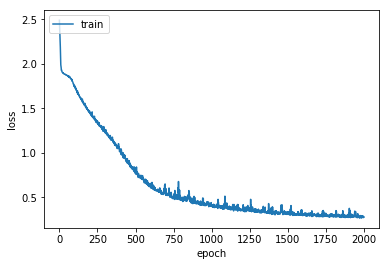

50/50 [==============================] - 0s 3ms/step
accuracy: 90.00%
one step prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'g4', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'e8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'f8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']
full song prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8']


In [34]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory() # 손실 이력 객체 생성
history.init()

# 5. 모델 학습시키기
model.fit(x_train, y_train, epochs=2000, batch_size=14, verbose=2, callbacks=[history])

# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4, 1)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)